<a href="https://colab.research.google.com/github/amishra15/RetailSalesAnalysis/blob/main/RetailSalesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohammadtalib786/retail-sales-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mohammadtalib786/retail-sales-dataset/versions/1


In [ ]:
import pandas as pd
csv_file_path = f"{path}/retail_sales_dataset.csv"
df = pd.read_csv(csv_file_path)

In [ ]:
df

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100
...,...,...,...,...,...,...,...,...,...
995,996,2023-05-16,CUST996,Male,62,Clothing,1,50,50
996,997,2023-11-17,CUST997,Male,52,Beauty,3,30,90
997,998,2023-10-29,CUST998,Female,23,Beauty,4,25,100
998,999,2023-12-05,CUST999,Female,36,Electronics,3,50,150


## Data Preprocessing

### Checking for missing values

In [ ]:
# Check for missing values in each column
missing_values = df.isnull().sum()

# Display missing values
print("Missing values per column:")
print(missing_values)

Missing values per column:
Transaction ID      0
Date                0
Customer ID         0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64


In [ ]:
# Optional: Display the percentage of missing values for context
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("\nPercentage of missing values per column:")
print(missing_percentage)


Percentage of missing values per column:
Transaction ID      0.0
Date                0.0
Customer ID         0.0
Gender              0.0
Age                 0.0
Product Category    0.0
Quantity            0.0
Price per Unit      0.0
Total Amount        0.0
dtype: float64


### Checking for Duplicates

In [ ]:
# Check for duplicate rows
duplicates = df.duplicated()

print(f"Number of duplicate rows: {duplicates.sum()}")

# Drop duplicates if any
df = df.drop_duplicates()


Number of duplicate rows: 0


### Handling Inconsistent Format

#### Categorical Data

In [ ]:
# Standardize string formatting for categorical columns
for col in df.select_dtypes(include=['object']):
    df[col] = df[col].str.strip().str.lower()


#### Date/Time Data

In [ ]:
# Example: Convert a column named 'date' to datetime format
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')


#### Verify Changes

In [ ]:
# Check the dataset info and preview changes
print("DataFrame info after preprocessing:")
print(df.info())

DataFrame info after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB
None


In [ ]:
# Display a sample of the data
print("Sample of the cleaned DataFrame:")
df


Sample of the cleaned DataFrame:


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,cust001,male,34,beauty,3,50,150
1,2,2023-02-27,cust002,female,26,clothing,2,500,1000
2,3,2023-01-13,cust003,male,50,electronics,1,30,30
3,4,2023-05-21,cust004,male,37,clothing,1,500,500
4,5,2023-05-06,cust005,male,30,beauty,2,50,100
...,...,...,...,...,...,...,...,...,...
995,996,2023-05-16,cust996,male,62,clothing,1,50,50
996,997,2023-11-17,cust997,male,52,beauty,3,30,90
997,998,2023-10-29,cust998,female,23,beauty,4,25,100
998,999,2023-12-05,cust999,female,36,electronics,3,50,150


### Adding External Features

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
import requests


In [ ]:
# Step 1: Add Holidays
def add_holidays(dataframe):
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=dataframe['Date'].min(), end=dataframe['Date'].max())
    dataframe['is_holiday'] = dataframe['Date'].isin(holidays).astype(int)
    return dataframe

# Check if 'Date' column exists in DataFrame
if 'Date' in df.columns:
    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert to datetime format

    # Add holidays
    df = add_holidays(df)

In [ ]:
# Step 2: Fetch Weather Data
def fetch_weather_data(lat, lon, start_date, end_date):
    url = f"https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
        "timezone": "auto"
    }
    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()
    weather_df = pd.DataFrame(data['daily'])
    weather_df['Date'] = pd.to_datetime(weather_df['time'])
    weather_df = weather_df.drop(columns=['time'])
    return weather_df

In [ ]:
# Ensuring 'date' column is in datetime format
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert to datetime format

# Define the date range for the weather data
start_date = df['Date'].min().strftime('%Y-%m-%d')
end_date = df['Date'].max().strftime('%Y-%m-%d')

# Fetch weather data
latitude = 40.7128
longitude = -74.0060
weather_data = fetch_weather_data(latitude, longitude, start_date, end_date)

In [ ]:
print("Columns in df:", df.columns)
print("Columns in weather_data:", weather_data.columns)


Columns in df: Index(['Transaction ID', 'Date', 'Customer ID', 'Gender', 'Age',
       'Product Category', 'Quantity', 'Price per Unit', 'Total Amount',
       'is_holiday'],
      dtype='object')
Columns in weather_data: Index(['temperature_2m_max', 'temperature_2m_min', 'precipitation_sum',
       'Date'],
      dtype='object')


In [ ]:
# Step 3: Merge Weather Data
df = df.merge(weather_data, on='Date', how='left')

In [ ]:
# Step 4: Verify Combined Data
def verify_data_combination(dataframe):
    print("\nSample of the combined DataFrame:")
    print(dataframe.head())
    print("\nColumns in the DataFrame:")
    print(dataframe.columns)

verify_data_combination(df)


Sample of the combined DataFrame:
   Transaction ID       Date Customer ID  Gender  Age Product Category  \
0               1 2023-11-24     cust001    male   34           beauty   
1               2 2023-02-27     cust002  female   26         clothing   
2               3 2023-01-13     cust003    male   50      electronics   
3               4 2023-05-21     cust004    male   37         clothing   
4               5 2023-05-06     cust005    male   30           beauty   

   Quantity  Price per Unit  Total Amount  is_holiday  temperature_2m_max  \
0         3              50           150           0                 9.7   
1         2             500          1000           0                 4.8   
2         1              30            30           0                12.6   
3         1             500           500           0                21.7   
4         2              50           100           0                20.9   

   temperature_2m_min  precipitation_sum  
0             

In [ ]:
df

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,is_holiday,temperature_2m_max,temperature_2m_min,precipitation_sum
0,1,2023-11-24,cust001,male,34,beauty,3,50,150,0,9.7,-0.6,0.0
1,2,2023-02-27,cust002,female,26,clothing,2,500,1000,0,4.8,-2.3,5.3
2,3,2023-01-13,cust003,male,50,electronics,1,30,30,0,12.6,2.8,1.4
3,4,2023-05-21,cust004,male,37,clothing,1,500,500,0,21.7,12.9,0.6
4,5,2023-05-06,cust005,male,30,beauty,2,50,100,0,20.9,6.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2023-05-16,cust996,male,62,clothing,1,50,50,0,27.6,12.7,0.0
996,997,2023-11-17,cust997,male,52,beauty,3,30,90,0,19.4,4.2,0.0
997,998,2023-10-29,cust998,female,23,beauty,4,25,100,0,15.0,10.5,7.6
998,999,2023-12-05,cust999,female,36,electronics,3,50,150,0,6.5,1.4,0.0


In [ ]:
# Group by 'Customer ID' to calculate customer-level metrics
customer_metrics = df.groupby('Customer ID').agg(
    total_spend=('Total Amount', 'sum'),       # Total spend by each customer
    avg_spend=('Total Amount', 'mean'),       # Average spend per transaction
    purchase_count=('Transaction ID', 'count') # Total number of transactions (repeat purchases)
).reset_index()

# Merge the customer-level metrics back into the main DataFrame
df = df.merge(customer_metrics, on='Customer ID', how='left')

# Display updated DataFrame
print("Updated DataFrame with Customer-Level Metrics:")
df


Updated DataFrame with Customer-Level Metrics:


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,is_holiday,...,precipitation_sum,total_spend_x,avg_spend_x,purchase_count_x,total_spend_y,avg_spend_y,purchase_count_y,total_spend,avg_spend,purchase_count
0,1,2023-11-24,cust001,male,34,beauty,3,50,150,0,...,0.0,150,150.0,1,150,150.0,1,150,150.0,1
1,2,2023-02-27,cust002,female,26,clothing,2,500,1000,0,...,5.3,1000,1000.0,1,1000,1000.0,1,1000,1000.0,1
2,3,2023-01-13,cust003,male,50,electronics,1,30,30,0,...,1.4,30,30.0,1,30,30.0,1,30,30.0,1
3,4,2023-05-21,cust004,male,37,clothing,1,500,500,0,...,0.6,500,500.0,1,500,500.0,1,500,500.0,1
4,5,2023-05-06,cust005,male,30,beauty,2,50,100,0,...,0.0,100,100.0,1,100,100.0,1,100,100.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2023-05-16,cust996,male,62,clothing,1,50,50,0,...,0.0,50,50.0,1,50,50.0,1,50,50.0,1
996,997,2023-11-17,cust997,male,52,beauty,3,30,90,0,...,0.0,90,90.0,1,90,90.0,1,90,90.0,1
997,998,2023-10-29,cust998,female,23,beauty,4,25,100,0,...,7.6,100,100.0,1,100,100.0,1,100,100.0,1
998,999,2023-12-05,cust999,female,36,electronics,3,50,150,0,...,0.0,150,150.0,1,150,150.0,1,150,150.0,1


In [ ]:
# Save the final DataFrame to a CSV file
final_csv_file_name = 'final_dataframe.csv'
df.to_csv(final_csv_file_name, index=False)

# Download the file to your local system
from google.colab import files
files.download(final_csv_file_name)

print(f"The final DataFrame has been saved as '{final_csv_file_name}' and is ready for download.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The final DataFrame has been saved as 'final_dataframe.csv' and is ready for download.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Transaction ID      1000 non-null   int64         
 1   Date                1000 non-null   datetime64[ns]
 2   Customer ID         1000 non-null   object        
 3   Gender              1000 non-null   object        
 4   Age                 1000 non-null   int64         
 5   Product Category    1000 non-null   object        
 6   Quantity            1000 non-null   int64         
 7   Price per Unit      1000 non-null   int64         
 8   Total Amount        1000 non-null   int64         
 9   is_holiday          1000 non-null   int64         
 10  temperature_2m_max  1000 non-null   float64       
 11  temperature_2m_min  1000 non-null   float64       
 12  precipitation_sum   1000 non-null   float64       
 13  total_spend_x       1000 non-null   int64        

## Exploratory Data Analysis (EDA)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the inline backend is used for plotting
%matplotlib inline


###  Top-Performing Products

Top-Performing Products:
                  total_sales  total_quantity
Product Category                             
electronics            156905             849
clothing               155580             894
beauty                 143515             771


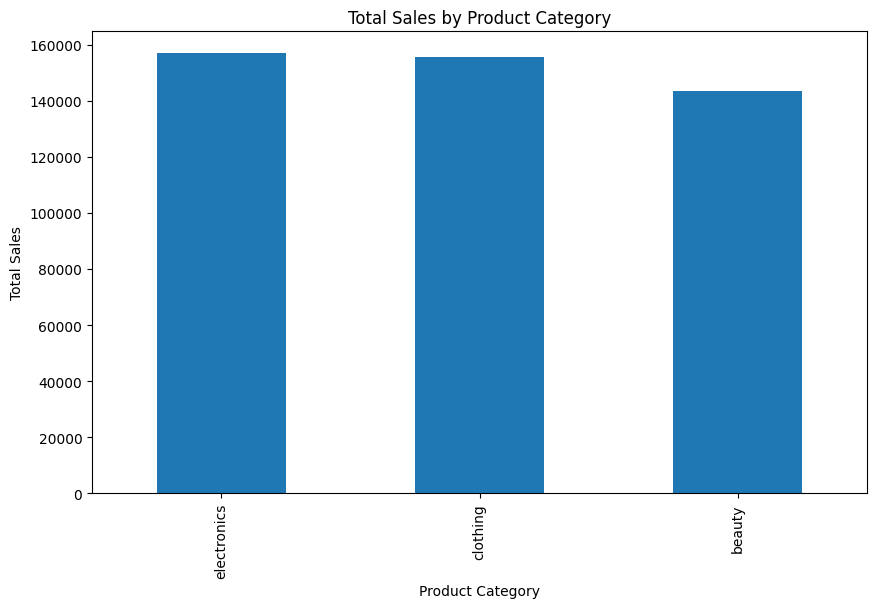

In [ ]:
# Group by Product Category to calculate total sales
product_performance = df.groupby('Product Category').agg(
    total_sales=('Total Amount', 'sum'),
    total_quantity=('Quantity', 'sum')
).sort_values(by='total_sales', ascending=False)

# Display top-performing products
print("Top-Performing Products:")
print(product_performance)

# Visualization: Bar chart of product performance
product_performance['total_sales'].plot(kind='bar', figsize=(10, 6), title="Total Sales by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Total Sales")
plt.show()


Observation:

Electronics lead in total sales, followed closely by Clothing and then Beauty.
The differences among categories are not stark, indicating fairly even contributions to total sales.

Insights:

Electronics might be driving sales due to higher price points or volume.
Clothing and Beauty represent strong secondary categories with room for expansion.

Actionable Insight:

Focus on promotional campaigns for top-performing categories like Electronics while exploring ways to expand the share of Beauty and Clothing through targeted marketing or new product introductions.

### Customer Segmentation

<ipython-input-60-01ec0e8ea717>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  customer_segments = df.groupby('Segment').agg(


Customer Segmentation:
                  customer_count    avg_spend  avg_purchase_count
Segment                                                          
Low Spender                  701   131.811698                 1.0
Moderate Spender             146   861.643836                 1.0
High Spender                 153  1554.248366                 1.0
VIP                            0          NaN                 NaN


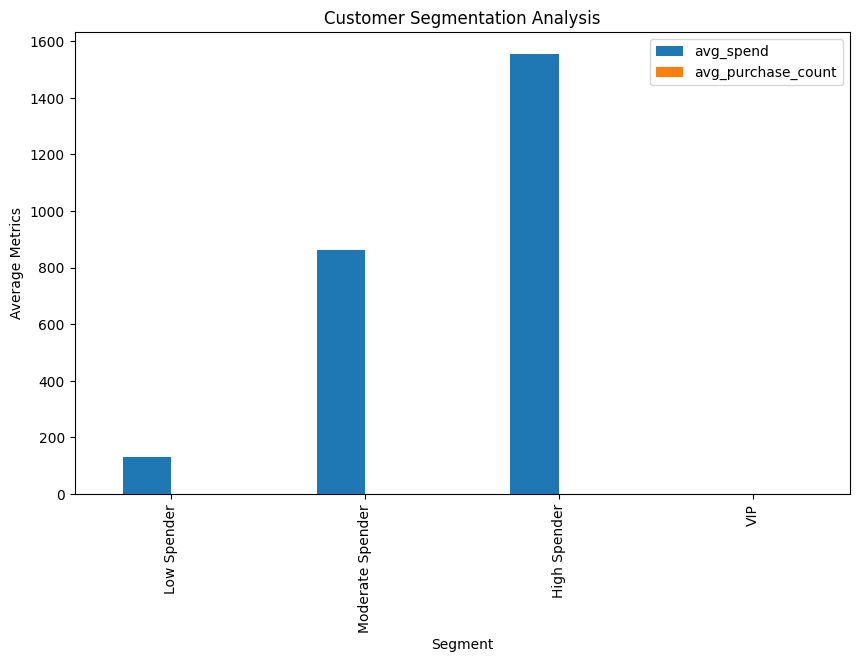

In [ ]:
# Define segments based on spend and purchase frequency
df['Segment'] = pd.cut(df['total_spend'], bins=[0, 500, 1000, 5000, float('inf')],
                       labels=['Low Spender', 'Moderate Spender', 'High Spender', 'VIP'])
customer_segments = df.groupby('Segment').agg(
    customer_count=('Customer ID', 'nunique'),
    avg_spend=('avg_spend', 'mean'),
    avg_purchase_count=('purchase_count', 'mean')
)

print("Customer Segmentation:")
print(customer_segments)

# Visualization: Clustered bar chart
customer_segments[['avg_spend', 'avg_purchase_count']].plot(
    kind='bar', figsize=(10, 6), title="Customer Segmentation Analysis"
)
plt.xlabel("Segment")
plt.ylabel("Average Metrics")
plt.show()


Observation:

The chart shows the average spending (avg_spend) and purchase count (avg_purchase_count) across customer segments.
High Spenders have significantly higher spending compared to Moderate and Low Spenders.
VIP customers have no data or are negligible in representation, indicating a gap in premium customer engagement.

Insights:

High Spenders are critical to revenue generation, contributing the most to the average metrics.
Moderate Spenders form a significant middle-tier, representing an opportunity for upselling.
Low Spenders indicate a segment that requires attention to increase retention and spending.

Actionable Insight:

Implement loyalty programs to retain High Spenders and convert Moderate Spenders to High Spenders.
Engage Low Spenders with discounts or bundled offers to increase their purchase frequency and value.

### Correlation Analysis

Correlation Matrix:
                    Total Amount  temperature_2m_max  temperature_2m_min  \
Total Amount            1.000000            0.015052           -0.004093   
temperature_2m_max      0.015052            1.000000            0.933985   
temperature_2m_min     -0.004093            0.933985            1.000000   
precipitation_sum       0.006616            0.039031            0.171111   
is_holiday              0.047673           -0.029963           -0.013626   

                    precipitation_sum  is_holiday  
Total Amount                 0.006616    0.047673  
temperature_2m_max           0.039031   -0.029963  
temperature_2m_min           0.171111   -0.013626  
precipitation_sum            1.000000   -0.059524  
is_holiday                  -0.059524    1.000000  


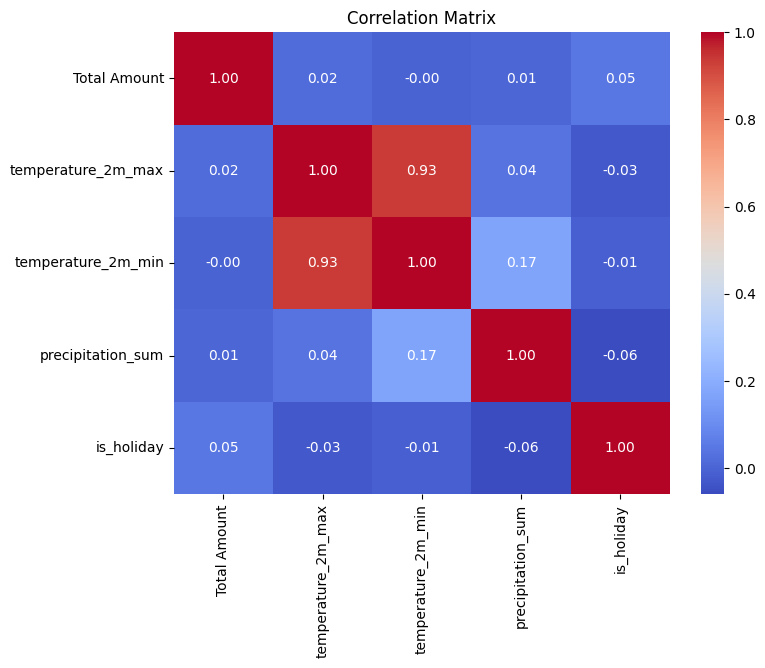

In [ ]:
# Correlation analysis
correlation_matrix = df[['Total Amount', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'is_holiday']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


Observation:

Sales (Total Amount) show weak correlations with weather variables (temperature and precipitation).
The correlation with holidays (is_holiday) is positive but also weak.

Insights:

External factors like weather and holidays might not significantly impact sales in this dataset.
Actionable insight: Focus on internal factors like pricing, product mix, and customer engagement for driving sales.

### Time Series Analysis

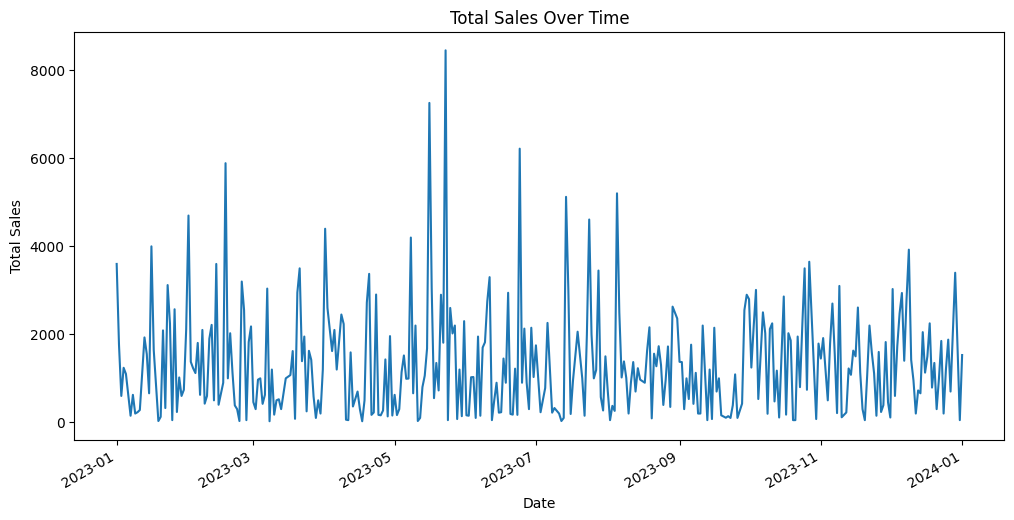

In [ ]:
# Aggregate sales over time
time_series = df.groupby('Date').agg(
    total_sales=('Total Amount', 'sum'),
    avg_sales=('Total Amount', 'mean')
)

# Visualization: Line plot for sales trends
time_series['total_sales'].plot(figsize=(12, 6), title="Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()


Observation:

The time series chart reveals fluctuations in total sales over time, with certain peaks and troughs.
Sales peaks are observed around mid-year (e.g., June and July), indicating possibly higher consumer activity during this period.
Lower sales are observed around the start and end of the year.

Insights:

Peaks in sales might align with specific events or seasons such as summer sales or promotional periods.
The troughs suggest periods of lower consumer spending, potentially during the post-holiday lull or non-promotional months.
Actionable insight: Plan promotional campaigns during low-sales periods and maximize marketing efforts during high-sales months.

## Advanced Analysis

### Regression Analysis: Drivers of Sales

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Select relevant features for regression
X = df[['temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'is_holiday', 'Quantity']]
y = df['Total Amount']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and fit the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Regression Model Evaluation:")
print("R-squared:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

# Display regression coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print("Regression Coefficients:")
print(coefficients)


Regression Model Evaluation:
R-squared: 0.08561238637524227
Mean Squared Error: 255600.94791102142
Regression Coefficients:
              Feature  Coefficient
0  temperature_2m_max     4.402047
1  temperature_2m_min    -6.429161
2   precipitation_sum     1.924976
3          is_holiday   121.512451
4            Quantity   201.687452


Observation:

The R-squared value is 0.085, which indicates the model explains only 8.5% of the variance in Total Amount. This suggests other unconsidered variables might significantly impact sales.
Coefficients:
Quantity has the highest positive influence (201.68), showing a direct and strong relationship with sales.
is_holiday has a moderate positive impact (121.51), indicating higher sales during holidays.
Weather factors (temperature_2m_max, temperature_2m_min, and precipitation_sum) have negligible impacts on sales.

Insights:

Sales are primarily driven by Quantity Sold and holiday effects.
Weather conditions do not significantly influence sales in this dataset.
Actionable Insight: Focus on increasing the quantity of products sold through promotions, bundling, and upselling during both holiday and non-holiday periods.

###  Customer Segmentation using K-Means Clustering

Customer Clusters Summary:
         avg_total_spend  avg_purchase_count  customer_count
Cluster                                                     
0             750.000000                 1.0               4
1             109.090909                 1.0              11
2            1566.666667                 1.0               3


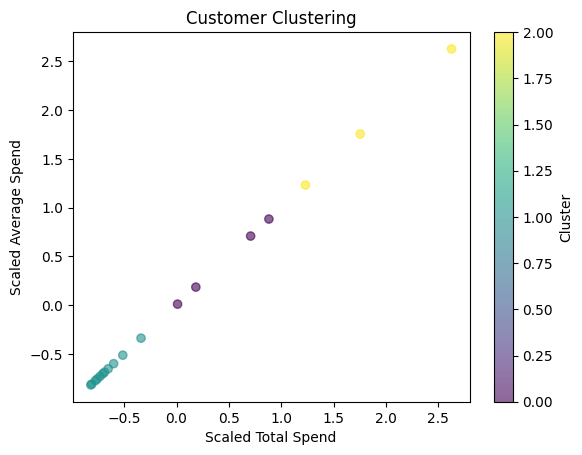

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
customer_data = df[['total_spend', 'avg_spend', 'purchase_count']].drop_duplicates().dropna()

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Analyze clusters
cluster_summary = customer_data.groupby('Cluster').agg(
    avg_total_spend=('total_spend', 'mean'),
    avg_purchase_count=('purchase_count', 'mean'),
    customer_count=('Cluster', 'size')
)
print("Customer Clusters Summary:")
print(cluster_summary)

# Visualization: Clustering
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=customer_data['Cluster'], cmap='viridis', alpha=0.6)
plt.title("Customer Clustering")
plt.xlabel("Scaled Total Spend")
plt.ylabel("Scaled Average Spend")
plt.colorbar(label="Cluster")
plt.show()


Observation:

Cluster 0: Customers with an average total spend of $750 and average purchase count of 1.0.
Cluster 1: Low-spending customers with an average total spend of $109 and purchase count of 1.0.
Cluster 2: High-spending customers (VIPs) with an average total spend of $1566 and purchase count of 1.0.

Insights:

Cluster 2 represents VIP customers, a small but critical segment contributing the most to revenue.
Cluster 1 has the largest customer count (11), indicating a significant proportion of low-value customers.
Cluster 0 comprises moderate spenders, providing opportunities for upselling.

Actionable Insight:

For Cluster 2 (VIPs): Retain through exclusive perks like loyalty programs or personalized offers.
For Cluster 0 (Moderate Spenders): Incentivize them to increase spending with discounts or targeted campaigns.
For Cluster 1 (Low Spenders): Engage with budget-friendly bundles and promotions to increase their contribution.

### Identify Patterns in Low-Performing Stores or Products

Low-Performing Products:
                  total_sales  total_quantity
Product Category                             
beauty                 143515             771


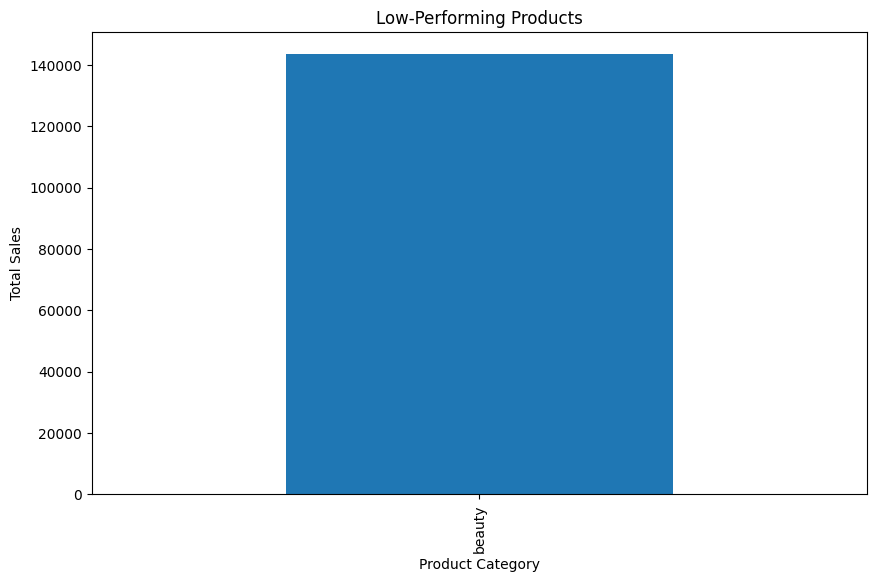

Actionable Recommendations:
- Analyze reasons for low sales (e.g., pricing, demand).
- Consider bundling these products with top-performers to boost visibility.
- Launch targeted marketing campaigns to improve sales.


In [ ]:
# Identify low-performing products
low_performing_products = product_performance[product_performance['total_sales'] < product_performance['total_sales'].quantile(0.25)]

print("Low-Performing Products:")
print(low_performing_products)

# Visualization: Bar chart of low-performing products
low_performing_products['total_sales'].plot(kind='bar', figsize=(10, 6), title="Low-Performing Products")
plt.xlabel("Product Category")
plt.ylabel("Total Sales")
plt.show()

# Actionable Recommendations for Low-Performing Products
print("Actionable Recommendations:")
print("- Analyze reasons for low sales (e.g., pricing, demand).")
print("- Consider bundling these products with top-performers to boost visibility.")
print("- Launch targeted marketing campaigns to improve sales.")


Observation:

The Beauty category is identified as a low-performing product, with total sales of $143,515 and total quantity sold of 771.
Its sales lag significantly behind other product categories, as shown in earlier charts.

Insights:

The low performance could stem from pricing, lower demand, or insufficient marketing.
This category still shows potential for improvement with the right strategies.

Actionable Recommendations:

Analyze Demand: Conduct market research to understand customer preferences for beauty products.
Bundle Products: Pair beauty items with high-performing categories like Electronics or Clothing to boost sales.
Promotions: Offer discounts or promotional campaigns to increase visibility and attract buyers.
Feedback: Collect customer feedback to identify gaps in product offerings or quality.
